In [1]:
# Identify whether a CUDA-enabled GPU is available
import pickle
import os
import sys

import torch
import numpy as np


sys.path.append("../..")

device = "cuda"

data_home = "../../artefacts/data"
with open(os.path.join(data_home, "train_dataset.pkl"), "rb") as f:
    train_dataset = pickle.load(f)

with open(os.path.join(data_home, "valid_dataset.pkl"), "rb") as f:
    valid_dataset = pickle.load(f)

meta_information = train_dataset.get_metadata()
SFREQ = 100

In [2]:
meta_information_valid = valid_dataset.get_metadata()
default_rmse_valid = meta_information_valid['target'].std()
default_rmse_train = meta_information['target'].std()

print(f"Default std on train: {default_rmse_train:.4f}, on valid: {default_rmse_valid:.4f}")

Default std on train: 0.4088, on valid: 0.4054


Symmetric window 30% (35-65): [1.49, 1.77] (width=0.28)
Symmetric window 50% (25-75): [1.38, 1.87] (width=0.49)
Median: 1.63


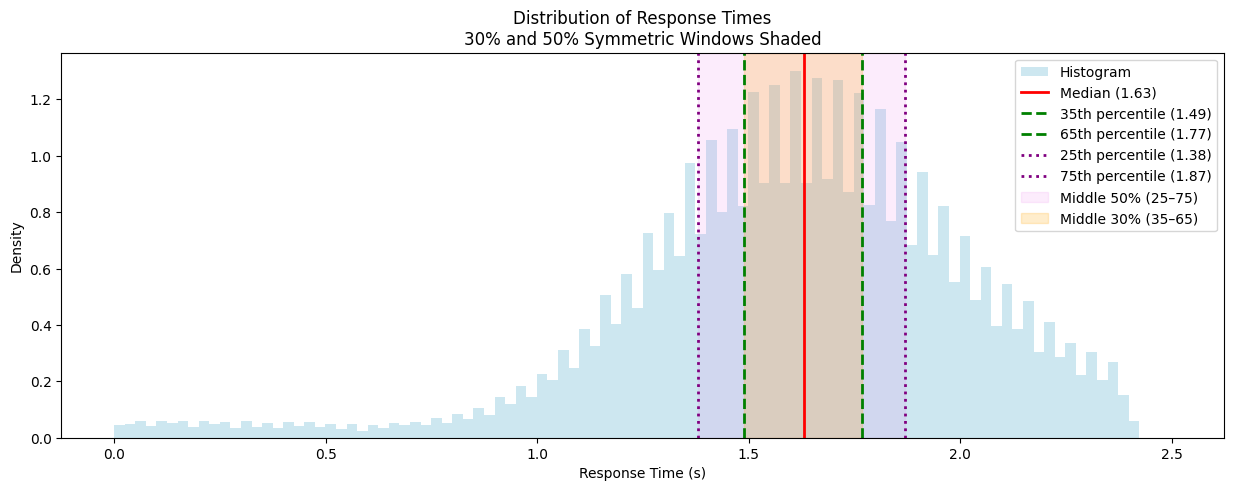

In [3]:
import matplotlib.pyplot as plt

target_data = meta_information["target"].values
sorted_data = np.sort(target_data)

# Calculate percentiles for 35-65 and 25-75 symmetric windows
lower_35 = np.percentile(sorted_data, 35)
upper_65 = np.percentile(sorted_data, 65)
lower_25 = np.percentile(sorted_data, 25)
upper_75 = np.percentile(sorted_data, 75)
median = np.median(sorted_data)

print(f"Symmetric window 30% (35-65): [{lower_35:.2f}, {upper_65:.2f}] (width={upper_65-lower_35:.2f})")
print(f"Symmetric window 50% (25-75): [{lower_25:.2f}, {upper_75:.2f}] (width={upper_75-lower_25:.2f})")
print(f"Median: {median:.2f}")

fig, ax = plt.subplots(figsize=(15, 5))
meta_information["target"].plot.hist(bins=100, ax=ax, color='lightblue', density=True, alpha=0.6, label='Histogram')
# Median
ax.axvline(median, color='red', linestyle='solid', linewidth=2, label=f"Median ({median:.2f})")
# 35-65 percentiles
ax.axvline(lower_35, color='green', linestyle='dashed', linewidth=2, label=f"35th percentile ({lower_35:.2f})")
ax.axvline(upper_65, color='green', linestyle='dashed', linewidth=2, label=f"65th percentile ({upper_65:.2f})")
# 25-75 percentiles
ax.axvline(lower_25, color='purple', linestyle='dotted', linewidth=2, label=f"25th percentile ({lower_25:.2f})")
ax.axvline(upper_75, color='purple', linestyle='dotted', linewidth=2, label=f"75th percentile ({upper_75:.2f})")
# Spans
ax.axvspan(lower_25, upper_75, color='violet', alpha=0.15, label='Middle 50% (25–75)')
ax.axvspan(lower_35, upper_65, color='orange', alpha=0.2, label='Middle 30% (35–65)')
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Density")
ax.set_title("Distribution of Response Times\n30% and 50% Symmetric Windows Shaded")
ax.legend()
plt.show()

### The rest is our classic PyTorch/torch lighting/skorch training pipeline

In [ ]:
from typing import Optional
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler
import torch.nn as nn

def train_one_epoch(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    optimizer,
    scheduler: Optional[LRScheduler],
    epoch: int,
    device,
    print_batch_stats: bool = True,
    channels_list: list = None,
    default_rmse: float = None,
):
    model.train()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_samples = 0

    progress_bar = tqdm(
        enumerate(dataloader), total=len(dataloader), disable=not print_batch_stats
    )    

    for batch_idx, batch in progress_bar:
        X, y = batch[0], batch[1]
        if channels_list is not None:
            X = X[:, channels_list, :]
        X, y = X.to(device).float(), y.to(device).float()
        
        # EEG channel-like random dropout augmentation
        channel_dropout_ratio = torch.rand(1).item() * 0.5
        if channel_dropout_ratio > 0:
            B, C, T = X.shape
            mask = (torch.rand(B, C, device=X.device) > channel_dropout_ratio).float().unsqueeze(-1)  # (B, C, 1)
            X = X * mask

        # With 50% probability, set a random segment of time steps to zero (length between 10 and 100)
        if torch.rand(1).item() < 0.5:
            B, C, T = X.shape
            for b in range(B):
                seg_len = int(torch.randint(10, min(100, T) + 1, (1,)).item())
                start = int(torch.randint(0, T - seg_len + 1, (1,)).item())
                X[b, :, start:start+seg_len] = 0
        # else:
        #     B, C, T = X.shape
        #     bin_sec = 1.0 / 100.0
        #     win = T*bin_sec
        #     k = int(torch.randint(-int(0.2*T), int(0.2*T)+1, (1,), device=X.device))
        #     if k > 0:  X = torch.cat([torch.zeros(B,C,k, device=X.device, dtype=X.dtype), X[...,:T-k]], -1)
        #     elif k < 0: X = torch.cat([X[...,-k:], torch.zeros(B,C,-k, device=X.device, dtype=X.dtype)], -1)
        #     y = torch.clamp(y + k*bin_sec, 0.0, win)

        # 1. Add Gaussian noise to the signals (with 20% chance)
        if torch.rand(1).item() < 0.2:
            noise_std = 0.03 * torch.randn(1).abs().item() + 0.01  # random std between 0.01 and ~0.04
            noise = torch.randn_like(X) * noise_std
            X = X + noise

        # --- Mixup augmentation (with target averaging) ---
        if torch.rand(1).item() < 0.5:  # 50% chance to apply
            alpha = 0.4  # Beta distribution parameter
            B = X.shape[0]
            perm = torch.randperm(B, device=X.device)

            # draw lambda from Beta(alpha, alpha)
            lam = torch.distributions.Beta(alpha, alpha).sample((B,)).to(X.device)
            lam_x = lam.view(B, 1, 1)  # for (B,C,T)
            lam_y = lam.view(B, 1)     # for (B,1) or (B,n_outputs)

            # mixup inputs and targets
            X = lam_x * X + (1 - lam_x) * X[perm]
            y = lam_y * y + (1 - lam_y) * y[perm]

        X = X.contiguous()

        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Flatten to 1D for regression metrics and accumulate squared error
        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5 / default_rmse
            progress_bar.set_description(
                f"Epoch {epoch}, Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {loss.item():.6f}, RMSE: {running_rmse:.6f}"
            )

        if scheduler is not None:
            scheduler.step()

    avg_loss = total_loss / len(dataloader)
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5 / default_rmse
    return avg_loss, rmse

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.nn import Module
from tqdm import tqdm
import numpy as np

@torch.no_grad()
def valid_model(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    device,
    print_batch_stats: bool = True,
    channels_list: list = None,
    default_rmse: float = None,
):
    model.eval()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_batches = len(dataloader)
    n_samples = 0

    iterator = tqdm(
        enumerate(dataloader),
        total=n_batches,
        disable=not print_batch_stats
    )
    cum_preds = []
    diffs = []

    for batch_idx, batch in iterator:
        X, y = batch[0], batch[1]
        if channels_list is not None:
            X = X[:, channels_list, :]
        X, y = X.to(device).float(), y.to(device).float()
        

        preds = model(X)
        batch_loss = loss_fn(preds, y).item()
        total_loss += batch_loss

        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()

        cum_preds.extend(preds_flat.cpu().numpy())
        diffs.extend((preds_flat - y_flat).cpu().numpy())
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5 / default_rmse
            iterator.set_description(
                f"Val Batch {batch_idx + 1}/{n_batches}, "
                f"Loss: {batch_loss:.6f}, RMSE: {running_rmse:.6f}"
            )

    avg_loss = total_loss / n_batches if n_batches else float("nan")
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5 / default_rmse
    acc_100 = np.mean(np.abs(diffs) < 0.1)
    acc_250 = np.mean(np.abs(diffs) < 0.25)

    print(f"Val RMSE: {rmse:.6f}, Val Loss: {avg_loss:.6f}, acc_100: {acc_100:.6f}, acc_250: {acc_250:.6f}")
    return cum_preds, avg_loss, rmse, acc_100, acc_250


## Example training with a small model

In this section, we demonstrate the training process on one of the smallest models in our suite.
Throughout the competition, our training process was highly exploratory and guided, meaning we constantly supervised and adjusted it manually whenever we didn’t like the intermediate behavior—changing hyperparameters, augmentations, or loss functions on the fly.

Despite this adaptive approach, the overall training framework remained consistent across all experiments.
We can distinguish two broad stages:

- Base training stage — initial convergence and general representation learning.
- Fine-tuning stage — refinement of the best-performing models on curated subsets or adjusted objectives.

In case of early stopping we are not stopping the process - just reloading the best model weights and continue training with decreased learning rate!

All architectures (SneddyNet, SneddyRTNet, DeepEEGRTNet, RecurTinyEEGRT, etc.) were trained within the same loop.
Each can be re-trained or fine-tuned by simply re-loading the best checkpoint and continuing training.

For demonstration purposes, below we show how training looks for SneddyNet, one of the lightest models in our collection.
You can uncomment any of the alternative architectures — they should all start training and reach a reasonable RMSE given enough time.
Occasionally, initialization leads to a poor start (NRMSE ≈ 1 not improving); in that case, simply restarting the script usually resolves it.

In [6]:
from neurosned.models.regression.sneddy_rt_net import SneddyRTNet
from neurosned.models.regression.sneddy_net import SneddyNet
from neurosned.models.regression.deep_eeg_net import DeepEEGRTNet
from neurosned.models.regression.reccurent_eegrt import RecurTinyEEGRT

# model = SneddyNet(
#     n_chans=129,
#     n_times=200,   
#     sfreq=100,
#     n_outputs=1,  
# )
model = SneddyNet(
    n_chans=129, n_times=200, sfreq=100, n_outputs=1,
    c0=48, widen=2, depth_per_stage=3, dropout=0.05, k=15
)
# model = SneddyRTNet(n_chans=128, n_times=200, sfreq=100,
#                         c0=64, widen=3, k=15, dropout=0.2,
#                         use_segpool=False,
#                         hi_dilations=(1,2,4,8), hi_depth=12,
#                         lo_dilations=(1,2,4,8), lo_depth=10, num_lo_stacks=3,
#                         downsample_once=True, downsample_twice=True, widen2=2)
# model = SneddyRTNet(
#     n_chans=128, n_times=200, sfreq=100,
#     c0=128, widen=3, k=11, dropout=0.30,
#     use_segpool=False,
#     hi_dilations=(1,2,4,8,16), hi_depth=20,
#     lo_dilations=(1,2,4,8,16), lo_depth=14,
#     num_lo_stacks=4,
#     downsample_once=True, downsample_twice=True, widen2=3
# )
# model = SneddyRTNet(
#     n_chans=128, n_times=200, sfreq=100,
#     c0=96, widen=3, k=15, dropout=0.30,
#     use_segpool=False,
#     hi_dilations=(1,2,4,8,16), hi_depth=16,
#     lo_dilations=(1,2,4,8,16), lo_depth=12,
#     num_lo_stacks=3,
#     downsample_once=True, downsample_twice=True, widen2=2
# )
# model = DeepEEGRTNet(
#         n_chans=128, n_times=200, sfreq=100.0,
#         c0=96, widen1=3, widen2=2, widen3=2,
#         k=15, dropout=0.150, layerscale_init=1e-4,
#         hi_dilations=(1,2,4,8,16), hi_depth=24,
#         lo1_dilations=(1,2,4,8,16), lo1_depth=16,
#         lo2_dilations=(1,2,4,8,16), lo2_depth=16,
#         lo3_dilations=(1,2,4,8,16), lo3_depth=12,
#         use_transformer=True, transformer_dim=256, transformer_heads=8, transformer_layers=2,
#         use_segpool=False
# )
# model = RecurTinyEEGRT(
#         n_chans=128,
#         n_times=200,
#         sfreq=100,
#         c0=64,
#         k_stem=9,
#         downsample_once=True,
#         downsample_twice=True,   # 200 → 100 → 50 time bins
#         widen1=2,
#         widen2=2,
#         max_steps=24,
#         core_k=9,
#         core_dilation=1,         # receptive field grows via recursion
#         core_dropout=0.10,
#         step_embed_dim=64,
#         film_hidden=128,
#         film_dropout=0.0,
#         use_act=True,
#         ponder_cost=0.01,
#         use_time_context=True,
#         time_ctx_dim=256,
#     )


In [7]:
input_checkpoint_path = "../../artefacts/models/challenge_1/regression_example_run.pth"
output_checkpoint_path = "../../artefacts/models/challenge_1/regression_example_run.pth"

if os.path.exists(input_checkpoint_path):
    model.load_state_dict(torch.load(input_checkpoint_path))
model.to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
bytes_total = total_params * 4  # float32 = 4 bytes
mb_total = bytes_total / 1024**2
gb_total = bytes_total / 1024**3

print(f"Total parameters: {total_params:,}")
print(f"Approximate model size: {mb_total:.2f} MB ({gb_total:.3f} GB)")


SneddyNet(
  (norm): StdPerSample()
  (c_squeeze): ChannelSqueeze(
    (proj): Conv1d(129, 48, kernel_size=(1,), stride=(1,), bias=False)
  )
  (backbone): Sequential(
    (0): ResBlock(
      (conv1): DSConv1d(
        (dw): Conv1d(48, 48, kernel_size=(15,), stride=(1,), padding=(7,), groups=48, bias=False)
        (pw): Conv1d(48, 48, kernel_size=(1,), stride=(1,), bias=False)
      )
      (gn1): GroupNorm(1, 48, eps=1e-05, affine=True)
      (conv2): DSConv1d(
        (dw): Conv1d(48, 48, kernel_size=(15,), stride=(1,), padding=(7,), groups=48, bias=False)
        (pw): Conv1d(48, 48, kernel_size=(1,), stride=(1,), bias=False)
      )
      (gn2): GroupNorm(1, 48, eps=1e-05, affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
      (act): GELU(approximate='none')
    )
    (1): ResBlock(
      (conv1): DSConv1d(
        (dw): Conv1d(48, 48, kernel_size=(15,), stride=(1,), padding=(7,), groups=48, bias=False)
        (pw): Conv1d(48, 48, kernel_size=(1,), stride=(1,), bias=

In [8]:
from torch.utils.data import DataLoader

finetune_mode = False
demonstration_mode = True

# process control
n_epochs = 10 if demonstration_mode else 100
early_stopping_patience = 8
channels_list = np.arange(model.n_chans)

# dataloading control
batch_size = 4000 if finetune_mode else 2000
num_workers = 6

# learning control
initial_lr = 1E-4 if finetune_mode else 1e-3
weight_decay = 0 if finetune_mode else 0
optimizer_module = torch.optim.SGD if finetune_mode else torch.optim.Adam

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=num_workers)

optimizer = optimizer_module(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
scheduler = None
loss_fn = torch.nn.MSELoss()

best_rmse = 1.
best_epoch = 0
epochs_no_improve = 0

In [9]:
current_lr = initial_lr

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}: ", end="")

    train_loss, train_rmse = train_one_epoch(
        train_loader, model, loss_fn, optimizer, scheduler, epoch, device, channels_list=channels_list, default_rmse=default_rmse_train
    )
    val_preds, val_loss, val_rmse, val_acc_100, val_acc_250 = valid_model(
        valid_loader, model, loss_fn, device, channels_list=channels_list, default_rmse=default_rmse_valid
    )
    print(
        f"Train RMSE: {train_rmse:.6f}, "
        f"Average Train Loss: {train_loss:.6f}, "
        f"Val RMSE: {val_rmse:.6f}, "
        f"Average Val Loss: {val_loss:.6f}"
    )
    if val_rmse < best_rmse:
        print(f"New best validation RMSE: {val_rmse:.6f} at epoch {epoch}")
        best_rmse = val_rmse
        best_epoch = epoch
        torch.save(model.state_dict(), output_checkpoint_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            current_checkpoint_path = output_checkpoint_path if os.path.exists(output_checkpoint_path) else input_checkpoint_path
            print(f"Restart from checkpoint {current_checkpoint_path}. Best Val NRMSE: {best_rmse:.6f} (epoch {best_epoch})")
            print(f"Updating learning rate {current_lr} -> {current_lr * 0.5}")
            model.load_state_dict(torch.load(current_checkpoint_path))
            current_lr = current_lr * 0.5
            optimizer = optimizer_module(model.parameters(), lr=current_lr, weight_decay=weight_decay)
            epochs_no_improve = 0


Epoch 1/10: 

Epoch 1, Batch 47/47, Loss: 0.200012, RMSE: 1.149020: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]
Val Batch 91/91, Loss: 0.035786, RMSE: 0.994176: 100%|██████████| 91/91 [00:03<00:00, 29.99it/s]

Val RMSE: 0.994176, Val Loss: 0.161133, acc_100: 0.224956, acc_250: 0.518851
Train RMSE: 1.149020, Average Train Loss: 0.220430, Val RMSE: 0.994176, Average Val Loss: 0.161133
New best validation RMSE: 0.994176 at epoch 1
Epoch 2/10: 


Epoch 2, Batch 47/47, Loss: 0.124421, RMSE: 0.968318: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]
Val Batch 91/91, Loss: 0.031873, RMSE: 0.990559: 100%|██████████| 91/91 [00:02<00:00, 30.67it/s]

Val RMSE: 0.990559, Val Loss: 0.159924, acc_100: 0.228947, acc_250: 0.524752
Train RMSE: 0.968318, Average Train Loss: 0.156334, Val RMSE: 0.990559, Average Val Loss: 0.159924
New best validation RMSE: 0.990559 at epoch 2
Epoch 3/10: 


Epoch 3, Batch 47/47, Loss: 0.134684, RMSE: 0.960330: 100%|██████████| 47/47 [00:12<00:00,  3.77it/s]
Val Batch 91/91, Loss: 0.032564, RMSE: 0.980089: 100%|██████████| 91/91 [00:02<00:00, 30.42it/s]

Val RMSE: 0.980089, Val Loss: 0.156575, acc_100: 0.239446, acc_250: 0.540371
Train RMSE: 0.960330, Average Train Loss: 0.153916, Val RMSE: 0.980089, Average Val Loss: 0.156575
New best validation RMSE: 0.980089 at epoch 3
Epoch 4/10: 


Epoch 4, Batch 47/47, Loss: 0.137027, RMSE: 0.953270: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]
Val Batch 91/91, Loss: 0.039888, RMSE: 0.970442: 100%|██████████| 91/91 [00:03<00:00, 29.81it/s]

Val RMSE: 0.970442, Val Loss: 0.153593, acc_100: 0.248948, acc_250: 0.553126
Train RMSE: 0.953270, Average Train Loss: 0.151714, Val RMSE: 0.970442, Average Val Loss: 0.153593
New best validation RMSE: 0.970442 at epoch 4
Epoch 5/10: 


Epoch 5, Batch 47/47, Loss: 0.168715, RMSE: 0.936038: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]
Val Batch 91/91, Loss: 0.035159, RMSE: 0.963203: 100%|██████████| 91/91 [00:03<00:00, 30.14it/s]

Val RMSE: 0.963203, Val Loss: 0.151266, acc_100: 0.258796, acc_250: 0.568658
Train RMSE: 0.936038, Average Train Loss: 0.146727, Val RMSE: 0.963203, Average Val Loss: 0.151266
New best validation RMSE: 0.963203 at epoch 5
Epoch 6/10: 


Epoch 6, Batch 47/47, Loss: 0.193878, RMSE: 0.943665: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s]
Val Batch 91/91, Loss: 0.039410, RMSE: 0.969435: 100%|██████████| 91/91 [00:03<00:00, 28.87it/s]

Val RMSE: 0.969435, Val Loss: 0.153270, acc_100: 0.248905, acc_250: 0.560111
Train RMSE: 0.943665, Average Train Loss: 0.149402, Val RMSE: 0.969435, Average Val Loss: 0.153270
Epoch 7/10: 


Epoch 7, Batch 47/47, Loss: 0.154410, RMSE: 0.952078: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s]
Val Batch 91/91, Loss: 0.044873, RMSE: 0.977841: 100%|██████████| 91/91 [00:03<00:00, 29.82it/s]

Val RMSE: 0.977841, Val Loss: 0.155990, acc_100: 0.246996, acc_250: 0.555816
Train RMSE: 0.952078, Average Train Loss: 0.151552, Val RMSE: 0.977841, Average Val Loss: 0.155990
Epoch 8/10: 


Epoch 8, Batch 47/47, Loss: 0.105750, RMSE: 0.939192: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s]
Val Batch 91/91, Loss: 0.041440, RMSE: 0.961195: 100%|██████████| 91/91 [00:03<00:00, 29.56it/s]

Val RMSE: 0.961195, Val Loss: 0.150704, acc_100: 0.278320, acc_250: 0.589830
Train RMSE: 0.939192, Average Train Loss: 0.146932, Val RMSE: 0.961195, Average Val Loss: 0.150704
New best validation RMSE: 0.961195 at epoch 8
Epoch 9/10: 


Epoch 9, Batch 47/47, Loss: 0.144827, RMSE: 0.936922: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]
Val Batch 91/91, Loss: 0.034751, RMSE: 0.953417: 100%|██████████| 91/91 [00:03<00:00, 29.92it/s]

Val RMSE: 0.953417, Val Loss: 0.148211, acc_100: 0.278754, acc_250: 0.586793
Train RMSE: 0.936922, Average Train Loss: 0.146707, Val RMSE: 0.953417, Average Val Loss: 0.148211
New best validation RMSE: 0.953417 at epoch 9
Epoch 10/10: 


Epoch 10, Batch 47/47, Loss: 0.118047, RMSE: 0.927937: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]
Val Batch 91/91, Loss: 0.031812, RMSE: 0.952251: 100%|██████████| 91/91 [00:03<00:00, 30.18it/s]

Val RMSE: 0.952251, Val Loss: 0.147818, acc_100: 0.274589, acc_250: 0.584190
Train RMSE: 0.927937, Average Train Loss: 0.143613, Val RMSE: 0.952251, Average Val Loss: 0.147818
New best validation RMSE: 0.952251 at epoch 10


## Finetune Stage

In [29]:
input_checkpoint_path = "../../artefacts/models/challenge_1/regression_example_run.pth"
output_checkpoint_path = "../../artefacts/models/challenge_1/regression_example_run.pth"

if os.path.exists(input_checkpoint_path):
    print(f"Loaded model from {input_checkpoint_path}")
    model.load_state_dict(torch.load(input_checkpoint_path))
    val_preds, val_loss, best_rmse, val_acc_100, val_acc_250 = valid_model(
        valid_loader, model, loss_fn, device, channels_list=channels_list, default_rmse=default_rmse_valid
    )
model.to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
bytes_total = total_params * 4  # float32 = 4 bytes
mb_total = bytes_total / 1024**2
gb_total = bytes_total / 1024**3

print(f"Total parameters: {total_params:,}")
print(f"Approximate model size: {mb_total:.2f} MB ({gb_total:.3f} GB)")


Loaded model from ../../artefacts/models/challenge_1/regression_example_run.pth


Val Batch 91/91, Loss: 0.033020, RMSE: 0.951705: 100%|██████████| 91/91 [00:03<00:00, 30.09it/s]

Val RMSE: 0.951705, Val Loss: 0.147662, acc_100: 0.275847, acc_250: 0.581804
SneddyNet(
  (norm): StdPerSample()
  (c_squeeze): ChannelSqueeze(
    (proj): Conv1d(129, 48, kernel_size=(1,), stride=(1,), bias=False)
  )
  (backbone): Sequential(
    (0): ResBlock(
      (conv1): DSConv1d(
        (dw): Conv1d(48, 48, kernel_size=(15,), stride=(1,), padding=(7,), groups=48, bias=False)
        (pw): Conv1d(48, 48, kernel_size=(1,), stride=(1,), bias=False)
      )
      (gn1): GroupNorm(1, 48, eps=1e-05, affine=True)
      (conv2): DSConv1d(
        (dw): Conv1d(48, 48, kernel_size=(15,), stride=(1,), padding=(7,), groups=48, bias=False)
        (pw): Conv1d(48, 48, kernel_size=(1,), stride=(1,), bias=False)
      )
      (gn2): GroupNorm(1, 48, eps=1e-05, affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
      (act): GELU(approximate='none')
    )
    (1): ResBlock(
      (conv1): DSConv1d(
        (dw): Conv1d(48, 48, kernel_size=(15,), stride=(1,), padding=(7,), groups=48, 

In [30]:
from torch.utils.data import DataLoader

finetune_mode = True
demonstration_mode = True

# process control
n_epochs = 10 if demonstration_mode else 100
early_stopping_patience = 8
channels_list = np.arange(model.n_chans)

# dataloading control
batch_size = 3000 if finetune_mode else 2000
num_workers = 6

# learning control
initial_lr = 1E-4 if finetune_mode else 1e-3
weight_decay = 0 if finetune_mode else 0
optimizer_module = torch.optim.SGD if finetune_mode else torch.optim.Adam

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=num_workers)

optimizer = optimizer_module(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
scheduler = None
loss_fn = torch.nn.MSELoss()

best_epoch = 0
epochs_no_improve = 0

In [31]:
current_lr = initial_lr

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}: ", end="")

    train_loss, train_rmse = train_one_epoch(
        train_loader, model, loss_fn, optimizer, scheduler, epoch, device, channels_list=channels_list, default_rmse=default_rmse_train
    )
    val_preds, val_loss, val_rmse, val_acc_100, val_acc_250 = valid_model(
        valid_loader, model, loss_fn, device, channels_list=channels_list, default_rmse=default_rmse_valid
    )
    print(
        f"Train RMSE: {train_rmse:.6f}, "
        f"Average Train Loss: {train_loss:.6f}, "
        f"Val RMSE: {val_rmse:.6f}, "
        f"Average Val Loss: {val_loss:.6f}"
    )
    if val_rmse < best_rmse:
        print(f"New best validation RMSE: {val_rmse:.6f} at epoch {epoch}")
        best_rmse = val_rmse
        best_epoch = epoch
        torch.save(model.state_dict(), output_checkpoint_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            current_checkpoint_path = output_checkpoint_path if os.path.exists(output_checkpoint_path) else input_checkpoint_path
            print(f"Restart from checkpoint {current_checkpoint_path}. Best Val NRMSE: {best_rmse:.6f} (epoch {best_epoch})")
            print(f"Updating learning rate {current_lr} -> {current_lr * 0.5}")
            model.load_state_dict(torch.load(current_checkpoint_path))
            current_lr = current_lr * 0.5
            optimizer = optimizer_module(model.parameters(), lr=current_lr, weight_decay=weight_decay)
            epochs_no_improve = 0


Epoch 1/10: 

Epoch 1, Batch 31/31, Loss: 0.128727, RMSE: 0.932900: 100%|██████████| 31/31 [00:13<00:00,  2.31it/s]
Val Batch 91/91, Loss: 0.033075, RMSE: 0.951250: 100%|██████████| 91/91 [00:03<00:00, 29.89it/s]

Val RMSE: 0.951250, Val Loss: 0.147522, acc_100: 0.275977, acc_250: 0.582758
Train RMSE: 0.932900, Average Train Loss: 0.145447, Val RMSE: 0.951250, Average Val Loss: 0.147522
New best validation RMSE: 0.951250 at epoch 1
Epoch 2/10: 


Epoch 2, Batch 31/31, Loss: 0.142639, RMSE: 0.939015: 100%|██████████| 31/31 [00:13<00:00,  2.31it/s]
Val Batch 91/91, Loss: 0.033169, RMSE: 0.950992: 100%|██████████| 91/91 [00:03<00:00, 30.22it/s]

Val RMSE: 0.950992, Val Loss: 0.147443, acc_100: 0.276151, acc_250: 0.583756
Train RMSE: 0.939015, Average Train Loss: 0.147379, Val RMSE: 0.950992, Average Val Loss: 0.147443
New best validation RMSE: 0.950992 at epoch 2
Epoch 3/10: 


Epoch 3, Batch 31/31, Loss: 0.161248, RMSE: 0.940410: 100%|██████████| 31/31 [00:13<00:00,  2.30it/s]
Val Batch 91/91, Loss: 0.033555, RMSE: 0.951050: 100%|██████████| 91/91 [00:03<00:00, 30.15it/s]

Val RMSE: 0.951050, Val Loss: 0.147465, acc_100: 0.277409, acc_250: 0.583843
Train RMSE: 0.940410, Average Train Loss: 0.147847, Val RMSE: 0.951050, Average Val Loss: 0.147465
Epoch 4/10: 


Epoch 4, Batch 31/31, Loss: 0.129463, RMSE: 0.938139: 100%|██████████| 31/31 [00:13<00:00,  2.28it/s]
Val Batch 91/91, Loss: 0.033862, RMSE: 0.951075: 100%|██████████| 91/91 [00:03<00:00, 29.65it/s]

Val RMSE: 0.951075, Val Loss: 0.147476, acc_100: 0.276975, acc_250: 0.583756
Train RMSE: 0.938139, Average Train Loss: 0.147084, Val RMSE: 0.951075, Average Val Loss: 0.147476
Epoch 5/10: 


Epoch 5, Batch 31/31, Loss: 0.157304, RMSE: 0.920145: 100%|██████████| 31/31 [00:13<00:00,  2.30it/s]
Val Batch 91/91, Loss: 0.033805, RMSE: 0.950669: 100%|██████████| 91/91 [00:02<00:00, 30.63it/s]

Val RMSE: 0.950669, Val Loss: 0.147350, acc_100: 0.277279, acc_250: 0.584798
Train RMSE: 0.920145, Average Train Loss: 0.141549, Val RMSE: 0.950669, Average Val Loss: 0.147350
New best validation RMSE: 0.950669 at epoch 5
Epoch 6/10: 


Epoch 6, Batch 31/31, Loss: 0.161349, RMSE: 0.936838: 100%|██████████| 31/31 [00:13<00:00,  2.31it/s]
Val Batch 91/91, Loss: 0.033825, RMSE: 0.950481: 100%|██████████| 91/91 [00:02<00:00, 30.43it/s]

Val RMSE: 0.950481, Val Loss: 0.147292, acc_100: 0.279492, acc_250: 0.584841
Train RMSE: 0.936838, Average Train Loss: 0.146729, Val RMSE: 0.950481, Average Val Loss: 0.147292
New best validation RMSE: 0.950481 at epoch 6
Epoch 7/10: 


Epoch 7, Batch 31/31, Loss: 0.119194, RMSE: 0.929885: 100%|██████████| 31/31 [00:13<00:00,  2.33it/s]
Val Batch 91/91, Loss: 0.034324, RMSE: 0.950874: 100%|██████████| 91/91 [00:02<00:00, 30.48it/s]

Val RMSE: 0.950874, Val Loss: 0.147419, acc_100: 0.277149, acc_250: 0.583887
Train RMSE: 0.929885, Average Train Loss: 0.144494, Val RMSE: 0.950874, Average Val Loss: 0.147419
Epoch 8/10: 


Epoch 8, Batch 31/31, Loss: 0.155043, RMSE: 0.934179: 100%|██████████| 31/31 [00:13<00:00,  2.33it/s]
Val Batch 91/91, Loss: 0.034440, RMSE: 0.950714: 100%|██████████| 91/91 [00:03<00:00, 30.16it/s]

Val RMSE: 0.950714, Val Loss: 0.147370, acc_100: 0.277496, acc_250: 0.584103
Train RMSE: 0.934179, Average Train Loss: 0.145888, Val RMSE: 0.950714, Average Val Loss: 0.147370
Epoch 9/10: 


Epoch 9, Batch 31/31, Loss: 0.119473, RMSE: 0.926948: 100%|██████████| 31/31 [00:13<00:00,  2.32it/s]
Val Batch 91/91, Loss: 0.034608, RMSE: 0.950646: 100%|██████████| 91/91 [00:02<00:00, 30.69it/s]

Val RMSE: 0.950646, Val Loss: 0.147351, acc_100: 0.278233, acc_250: 0.584711
Train RMSE: 0.926948, Average Train Loss: 0.143584, Val RMSE: 0.950646, Average Val Loss: 0.147351
Epoch 10/10: 


Epoch 10, Batch 31/31, Loss: 0.168367, RMSE: 0.918377: 100%|██████████| 31/31 [00:13<00:00,  2.31it/s]
Val Batch 91/91, Loss: 0.034534, RMSE: 0.950417: 100%|██████████| 91/91 [00:02<00:00, 30.46it/s]

Val RMSE: 0.950417, Val Loss: 0.147280, acc_100: 0.279492, acc_250: 0.584581
Train RMSE: 0.918377, Average Train Loss: 0.141024, Val RMSE: 0.950417, Average Val Loss: 0.147280
New best validation RMSE: 0.950417 at epoch 10


## Analysis of predictions

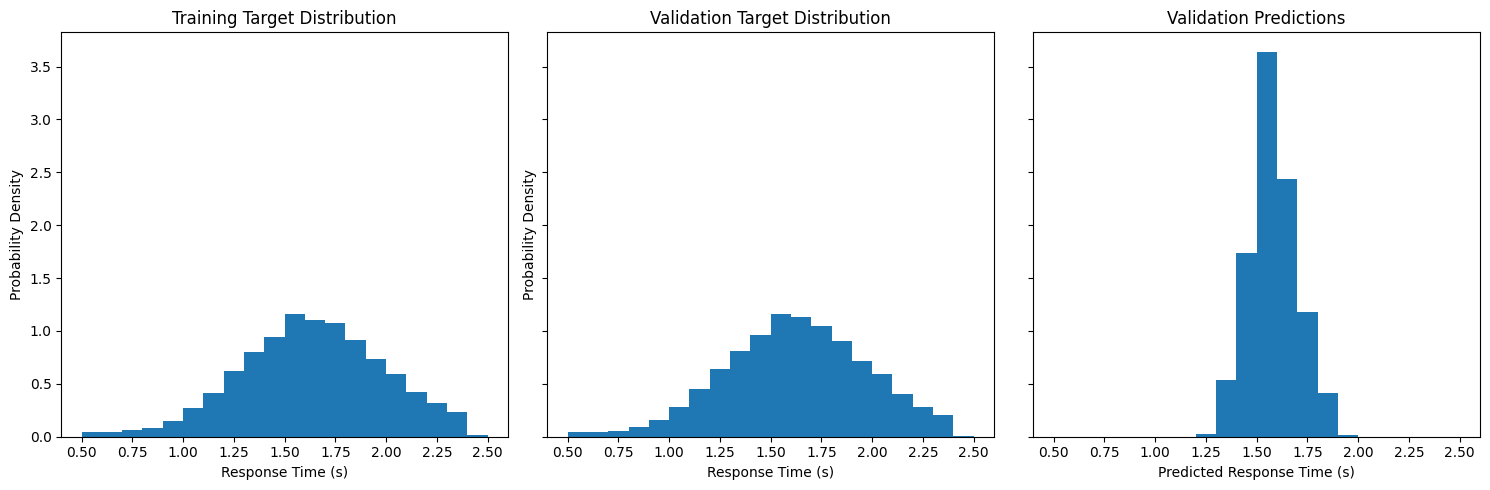

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Left plot: Training data distribution
ax[0].hist(meta_information['target'], bins=20, range=(0.5, 2.5), density=True)
ax[0].set_title("Training Target Distribution")
ax[0].set_xlabel("Response Time (s)")
ax[0].set_ylabel("Probability Density")

ax[1].hist(meta_information_valid['target'], bins=20, range=(0.5, 2.5), density=True)
ax[1].set_title("Validation Target Distribution")
ax[1].set_xlabel("Response Time (s)")
ax[1].set_ylabel("Probability Density")

# Right plot: Validation predictions distribution
ax[2].hist(val_preds, bins=20, range=(0.5, 2.5), density=True)
ax[2].set_title("Validation Predictions")
ax[2].set_xlabel("Predicted Response Time (s)")

plt.tight_layout()
plt.show()